**LOAD LIBRARY**

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

**LOAD DATA**

In [2]:
# load data
df = pd.read_csv('/Users/phongporter/Documents/GITHUB/cos30018/optionB/B.1/StockPredictionPrice/B/5/dataset/AMZN_2020-01-01_2023-01-01.csv')

In [3]:
df

,Unnamed: 0,open,high,low,close,adjclose,volume,ticker
0,2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000,AMZN
1,2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000,AMZN
2,2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000,AMZN
3,2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000,AMZN
4,2020-01-08,94.902000,95.550003,94.321999,94.598503,94.598503,70160000,AMZN
...,...,...,...,...,...,...,...,...
751,2022-12-23,83.250000,85.779999,82.930000,85.250000,85.250000,57433700,AMZN
752,2022-12-27,84.970001,85.349998,83.000000,83.040001,83.040001,57284000,AMZN
753,2022-12-28,82.800003,83.480003,81.690002,81.820000,81.820000,58228600,AMZN
754,2022-12-29,82.870003,84.550003,82.550003,84.180000,84.180000,54995900,AMZN


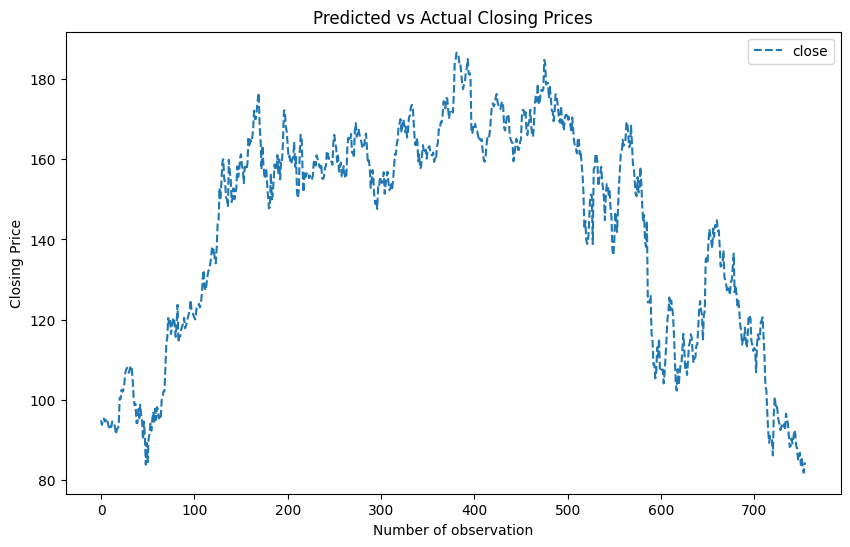

In [4]:
# Plotting the line chart for predicted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(df['close'], label='close', linestyle='--')

plt.title('Predicted vs Actual Closing Prices')
plt.xlabel('Number of observation')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# 1. Multistep prediction

In [5]:
def prepare_multistep_data(data, target, n_steps, k):
    # Normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data[[target]].values)
    #print(data.shape)
    #predict k features day based on number of past days
    X, y = [], []
    for i in range(len(data_scaled) - n_steps - k + 1):  #apply Window Slicing
        X.append(data_scaled[i:i+n_steps, 0])
        y.append(data_scaled[i+n_steps:i+n_steps+k, 0])
    return np.array(X), np.array(y), scaler

In [6]:
n_steps = 30  # Number of past days lookback
k = 5         # Number of future days to predict
X, y, scaler = prepare_multistep_data(df, 'close', n_steps, k)

In [7]:
X = X.reshape((X.shape[0], X.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [8]:
#build multistep model
def build_multistep_model(n_steps, k):
    model = Sequential()
    model.add(Input(shape=(n_steps, 1)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(k))
    model.compile(optimizer='adam', loss='mse')
    return model

In [9]:
multistep_model = build_multistep_model(n_steps, k)
history = multistep_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.4250 - val_loss: 0.0378
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1071 - val_loss: 0.0106
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0172 - val_loss: 0.0110
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0075 - val_loss: 0.0114
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0069 - val_loss: 0.0119
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0066 - val_loss: 0.0128
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0075 - val_loss: 0.0127
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0067 - val_loss: 0.0113
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0067 - val_loss: 0.0098
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0069 - val_loss: 0.0097
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0069 - val_loss: 0.0097
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

In [10]:
# Test prediction
y_pred_scaled = multistep_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_original = scaler.inverse_transform(y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [11]:
y_pred_df1 = pd.DataFrame({
    'Predicted': y_pred.flatten(),
    'Actual': y_test_original.flatten()
})

#5 column for each prediction
y_pred_df1.head(5)   # first observation

,Predicted,Actual
0,110.857689,120.209503
1,111.632980,121.683998
2,112.035896,125.511002
3,111.727699,122.349998
4,113.920219,124.790001


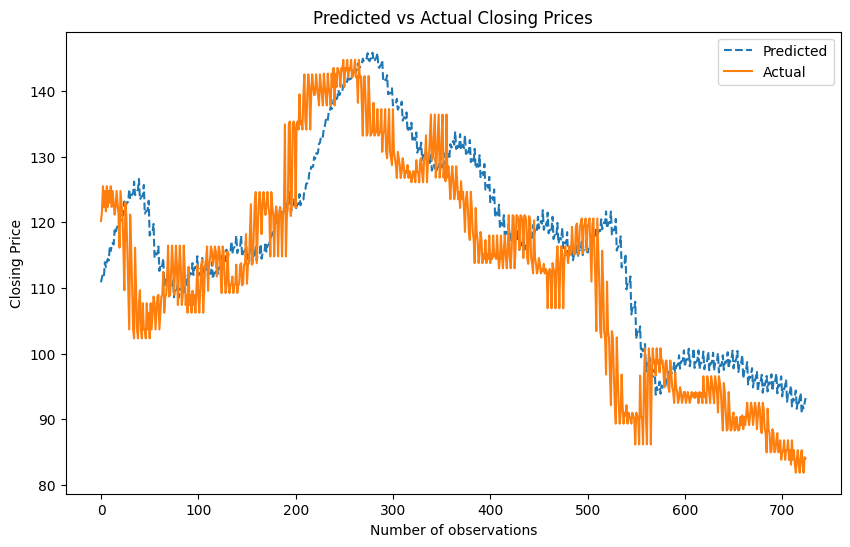

In [12]:
# Plotting the line chart for predicted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_pred_df1['Predicted'], label='Predicted', linestyle='--')
plt.plot(y_pred_df1['Actual'], label='Actual', linestyle='-')

plt.title('Predicted vs Actual Closing Prices')
plt.xlabel('Number of observations')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# 2. Multivariate Prediction

1. All var --> k days
2. Constant vars --> 1 days
3. Constant vars --> k days

In [13]:
def preprocess_multivariate_single_step(data, features, target_column, n_steps):
    # Normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data[features].values)

    X, y = [], []

    for i in range(len(data_scaled) - n_steps):
        X.append(data_scaled[i:i+n_steps])  # Past n_steps of features
        y.append(data_scaled[i+n_steps, features.index(target_column)])

    X = np.array(X)
    y = np.array(y)
    return X, y, scaler

In [14]:
n_steps = 30  # Use the past 30 days to predict the next day
features = ['open', 'high', 'low', 'adjclose', 'volume', 'close']
target_column = 'close'

X, y, scaler = preprocess_multivariate_single_step(df, features, target_column, n_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [15]:
def build_multivariate_single_step_model(n_steps, n_features):
    model = Sequential()
    model.add(Input(shape=(n_steps, n_features)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

n_steps = 30
n_features = len(features)  # Number of features used in prediction
multivariate_single_step_model = build_multivariate_single_step_model(n_steps, n_features)

In [16]:
history = multivariate_single_step_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1203 - val_loss: 0.0045
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0055 - val_loss: 0.0035
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0023 - val_loss: 0.0035
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0

In [17]:
# Test prediction
y_pred_scaled = multivariate_single_step_model.predict(X_test)

y_pred_scaled_expanded = np.zeros((y_pred_scaled.shape[0], X_test.shape[2]))
y_pred_scaled_expanded[:, -1] = y_pred_scaled[:, 0]
y_pred = scaler.inverse_transform(y_pred_scaled_expanded)[:, -1]

y_test_expanded = np.zeros((y_test.shape[0], X_test.shape[2]))
y_test_expanded[:, -1] = y_test
y_test_original = scaler.inverse_transform(y_test_expanded)[:, -1]

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step


In [18]:
df_name_day = df['Unnamed: 0'][-146:].reset_index(drop=True)

In [19]:
y_pred_df2 = pd.DataFrame({
    'Day': df_name_day,
    'Predicted': y_pred.flatten(),
    'Actual': y_test_original.flatten()
})

#5 column for each prediction
y_pred_df2.head(5)   #first

#this dataframe contains on the days in future (test set)

,Day,Predicted,Actual
0,2022-06-03,122.256982,122.349998
1,2022-06-06,123.775901,124.790001
2,2022-06-07,125.614434,123.000000
3,2022-06-08,125.576198,121.180000
4,2022-06-09,125.319476,116.150002


In [21]:
#1 column for each prediction
y_pred_df2.tail(5)   # 5 last days

,Day,Predicted,Actual
141,2022-12-23,87.945330,85.250000
142,2022-12-27,87.491677,83.040001
143,2022-12-28,87.170328,81.820000
144,2022-12-29,86.726596,84.180000
145,2022-12-30,86.773059,84.000000


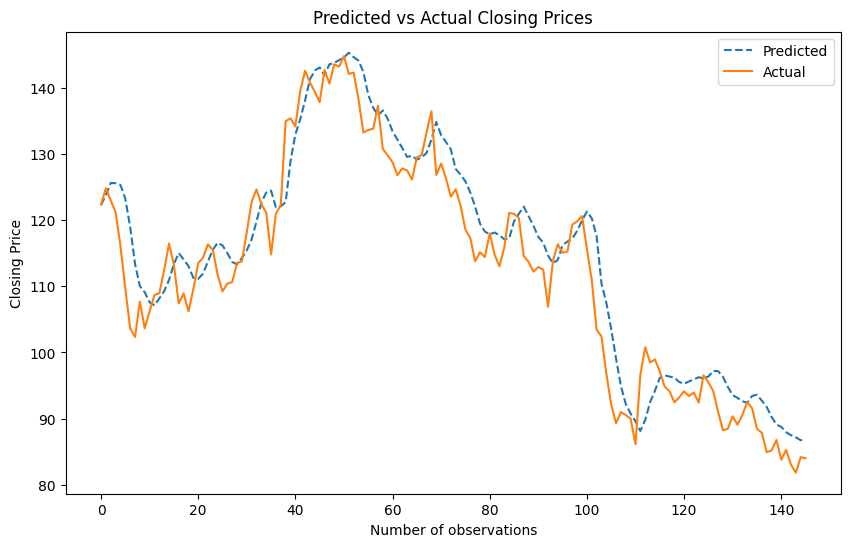

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(y_pred_df2['Predicted'], label='Predicted', linestyle='--')
plt.plot(y_pred_df2['Actual'], label='Actual', linestyle='-')

plt.title('Predicted vs Actual Closing Prices')
plt.xlabel('Number of observations')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# 3. Multivariate Multistep

In [23]:
def preprocess_multivariate_multistep(data, features, target_column, n_steps, k):
    # Normalize the features
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data[features].values)

    X, y = [], []

    for i in range(len(data_scaled) - n_steps - k + 1):
        X.append(data_scaled[i:i+n_steps])  # Past n_steps of features
        y.append(data_scaled[i+n_steps:i+n_steps+k, features.index(target_column)])

    X = np.array(X)
    y = np.array(y)
    return X, y, scaler

n_steps = 30  # Use the past 30 days to predict the next 'k' days
k = 4      # Predict the next 4 days
features = ['open', 'high', 'low', 'adjclose', 'volume', 'close']
#features = ['open', 'high', 'low','close']

# Preprocess the data
X, y, scaler = preprocess_multivariate_multistep(df, features, target_column='close', n_steps=n_steps, k=k)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [24]:
def build_multivariate_multistep_model(n_steps, n_features, k):

    model = Sequential()
    model.add(Input(shape=(n_steps, n_features)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(k))
    model.compile(optimizer='adam', loss='mse')
    return model

In [25]:
n_features = len(features)
multivariate_multistep_model = build_multivariate_multistep_model(n_steps, n_features, k)
history = multivariate_multistep_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3645 - val_loss: 0.0327
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0824 - val_loss: 0.0088
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0108 - val_loss: 0.0066
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0053 - val_loss: 0.0061
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0048 - val_loss: 0.0062
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0041 - val_loss: 0.0066
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0042 - val_loss: 0.0065
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0042 - val_loss: 0.0067
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0041 - val_loss: 0.0066
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0038 - val_loss: 0.0070
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0

In [26]:
# Test prediction
y_pred_scaled = multivariate_multistep_model.predict(X_test)

1/5 ━━━━━━━━━━━━━━━━━━━━ 3s 762ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


In [27]:
#scaler = MinMaxScaler(feature_range=(0, 1))
#data_scaled = scaler.fit_transform(df[features].values)

In [28]:
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_original = scaler.inverse_transform(y_test)

In [29]:
y_pred_df3 = pd.DataFrame({
    'Predicted': y_pred.flatten(),
    'Actual': y_test_original.flatten()
})

# column for each prediction
y_pred_df3

,Predicted,Actual
0,113.309616,122.081829
1,115.153893,127.347649
2,113.500099,121.362357
3,114.135025,124.790001
4,116.183464,125.922496
...,...,...
575,90.932915,84.180000
576,88.928856,83.299858
577,91.161514,83.480003
578,90.329964,83.634182


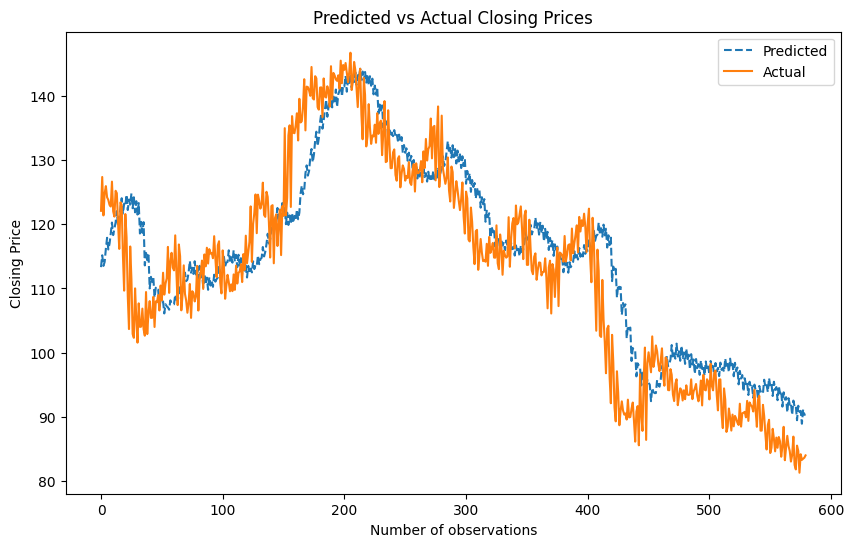

In [30]:
#rescaled
plt.figure(figsize=(10, 6))
plt.plot(y_pred_df3['Predicted'], label='Predicted', linestyle='--')
plt.plot(y_pred_df3['Actual'], label='Actual', linestyle='-')

plt.title('Predicted vs Actual Closing Prices')
plt.xlabel('Number of observations')
plt.ylabel('Closing Price')
plt.legend()
plt.show()